# Re-estimation of Analysis

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statsmodels

In [2]:
#%run Documents/GitHub/Thesis/DALY_WASH.ipynb
#%run Documents/GitHub/Thesis/ucdp_thesis.ipynb
#%run Documents/GitHub/Thesis/controls.ipynb
#%run Documents/GitHub/Thesis/merge_thesis.ipynb

In [3]:
##set a working directory
user = os.path.expanduser('~')
display(user)
os.makedirs(f'{user}/Desktop/private/thesis/', exist_ok=True)
path = os.chdir(f'{user}/Desktop/'+'private/thesis/')


'/Users/NatStrom'

In [4]:
data =pd.read_csv('data_final.csv')
print(data.columns)
display(data.describe())

Index(['Unnamed: 0', 'iso', 'year_id',
       'daly_mean_All causes_No access to handwashing facility_btsx_All ages',
       'daly_mean_All causes_Unsafe sanitation_btsx_All ages',
       'daly_mean_All causes_Unsafe water source_btsx_All ages',
       'daly_mean_Communicable, maternal, neonatal, and nutritional diseases_No access to handwashing facility_btsx_All ages',
       'daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe sanitation_btsx_All ages',
       'daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe water source_btsx_All ages',
       'daly_mean_Diarrheal diseases_No access to handwashing facility_btsx_All ages',
       'daly_mean_Diarrheal diseases_Unsafe sanitation_btsx_All ages',
       'daly_mean_Diarrheal diseases_Unsafe water source_btsx_All ages',
       'daly_mean_Enteric infections_No access to handwashing facility_btsx_All ages',
       'daly_mean_Enteric infections_Unsafe sanitation_btsx_All ages',
       'daly_m

,Unnamed: 0,year_id,daly_mean_All causes_No access to handwashing facility_btsx_All ages,daly_mean_All causes_Unsafe sanitation_btsx_All ages,daly_mean_All causes_Unsafe water source_btsx_All ages,"daly_mean_Communicable, maternal, neonatal, and nutritional diseases_No access to handwashing facility_btsx_All ages","daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe sanitation_btsx_All ages","daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe water source_btsx_All ages",daly_mean_Diarrheal diseases_No access to handwashing facility_btsx_All ages,daly_mean_Diarrheal diseases_Unsafe sanitation_btsx_All ages,...,tot_affect,pg_id,gdis_count,gdis_nunique,gdis_count_lag,daly_all,daly_respirat,daly_enteric,daly_diarrheal,daly_cmnn
count,25738.00000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,...,2.573800e+04,2.573800e+04,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000
mean,12868.50000,2007.886083,3728.352786,4731.743958,6478.474240,3728.352786,4731.743958,6478.474240,2407.283860,4731.743958,...,5.803149e+05,5.213953e+07,115.598376,97.380682,3.483464,14938.570985,2641.164504,13617.502059,13617.502059,14938.570985
std,7430.06495,8.959056,2161.793177,2909.144485,3942.039622,2161.793177,2909.144485,3942.039622,1482.360876,2909.144485,...,1.606693e+06,3.560595e+07,150.407029,122.146443,2.033905,8979.185496,1463.789589,8324.170822,8324.170822,8979.185496
min,0.00000,1990.000000,560.000000,484.000000,862.000000,560.000000,484.000000,862.000000,284.000000,484.000000,...,0.000000e+00,3.920820e+05,0.000000,0.000000,0.000000,1908.000000,328.000000,1630.000000,1630.000000,1908.000000
25%,6434.25000,2000.000000,1985.000000,2433.000000,3346.000000,1985.000000,2433.000000,3346.000000,1218.000000,2433.000000,...,7.190000e+03,2.808763e+07,9.000000,9.000000,2.302585,7713.000000,1434.000000,6777.000000,6777.000000,7713.000000
50%,12868.50000,2010.000000,3428.000000,4056.000000,5576.000000,3428.000000,4056.000000,5576.000000,2128.000000,4056.000000,...,3.691700e+04,4.468043e+07,45.000000,43.000000,3.828641,13383.000000,2538.000000,12010.000000,12010.000000,13383.000000
75%,19302.75000,2016.000000,4818.000000,6019.000000,8388.000000,4818.000000,6019.000000,8388.000000,3137.000000,6019.000000,...,2.538000e+05,9.575575e+07,197.000000,176.000000,5.288267,19280.000000,3438.000000,17646.000000,17646.000000,19280.000000
max,25737.00000,2019.000000,17536.000000,24562.000000,32010.000000,17536.000000,24562.000000,32010.000000,11715.000000,24562.000000,...,2.332957e+07,1.256802e+08,909.000000,778.000000,6.813445,74108.000000,11640.000000,68287.000000,68287.000000,74108.000000


In [5]:
#import population size
dta = pd.read_csv('pop_size.csv',skiprows= 4)
display(dta.columns)
display(dta)

#clean up
dta = dta.drop(columns=['Country Name','Indicator Name', 'Indicator Code','Unnamed: 67'])
dta = dta.rename(columns= {'Country Code':'iso'})
dta = dta.melt(id_vars='iso',var_name='year_id',value_name='pop_size')
dta['year_id'] = dta['year_id'].astype(str).astype(int)

## only years from 1990 onwards
dta = dta.loc[dta['year_id'] >= 1990]
dta = dta.loc[dta['year_id'] <= 2019]
#only countries in SSA
dta = dta.loc[dta['iso'].isin(['AGO', 'BDI', 'BEN', 'BFA', 'BWA', 'CAF', 'CIV', 'CMR', 'COD',
       'COG', 'COM', 'CPV', 'DJI', 'ERI', 'ETH', 'GAB', 'GHA', 'GIN',
       'GMB', 'GNB', 'GNQ', 'KEN', 'LBR', 'LSO', 'MDG', 'MLI', 'MOZ',
       'MRT', 'MWI', 'NAM', 'NER', 'NGA', 'RWA', 'SDN', 'SEN', 'SLE',
       'SOM', 'SSD', 'STP', 'SWZ', 'TCD', 'TGO', 'TZA', 'UGA', 'ZAF',
       'ZMB', 'ZWE'])]

#save
dta.to_csv('data_pop_size.csv')

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       'Unnamed: 67'],
      dtype='object')

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720839314.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1790133.0,1786038.0,1761985.0,NaN
262,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5542459.0,5646668.0,5753386.0,5860197.0,5973803.0,6097298.0,...,27753304.0,28516545.0,29274002.0,30034389.0,30790513.0,31546691.0,32284046.0,32981641.0,33696614.0,NaN
263,South Africa,ZAF,"Population, total",SP.POP.TOTL,16520441.0,16989464.0,17503133.0,18042215.0,18603097.0,19187194.0,...,54729551.0,55876504.0,56422274.0,56641209.0,57339635.0,58087055.0,58801927.0,59392255.0,59893885.0,NaN
264,Zambia,ZMB,"Population, total",SP.POP.TOTL,3119430.0,3219451.0,3323427.0,3431381.0,3542764.0,3658024.0,...,15737793.0,16248230.0,16767761.0,17298054.0,17835893.0,18380477.0,18927715.0,19473125.0,20017675.0,NaN


In [6]:
#merge the datasets on iso and year
data = pd.merge(data, dta, how="outer", on=["iso", "year_id"])
print(data.year_id.unique())

[1995 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2015 2016 2017 2018 2019 1992 2014 1991 1994 1996
 1990 1993]


# Vizualisation

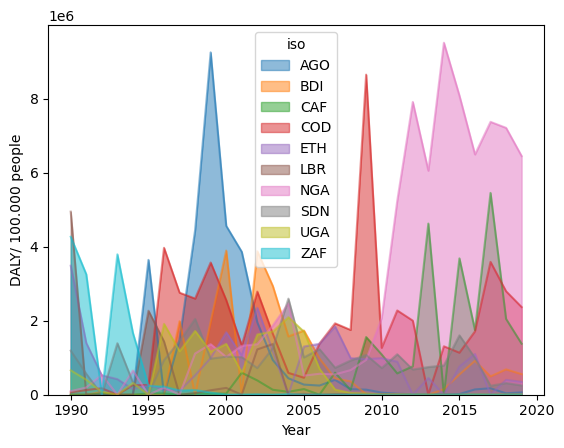

In [6]:
#time trend of the data
grouped = data.groupby(['iso', 'year_id']).agg({'daly_all': 'sum'})
top_countries = grouped.groupby('iso').agg({'daly_all': 'sum'}).nlargest(10, 'daly_all').index.tolist()
filtered = grouped[grouped.index.get_level_values('iso').isin(top_countries)]

pivoted = filtered.reset_index().pivot(index='year_id', columns='iso', values='daly_all')
pivoted.plot.area(stacked=False)

plt.xlabel('Year')
plt.ylabel('DALY/ 100.000 people')
plt.savefig('timetrend_daly.png')
# Show the plot
plt.show()

In [7]:
top_countries

['NGA', 'COD', 'AGO', 'SDN', 'ETH', 'CAF', 'BDI', 'UGA', 'ZAF', 'LBR']

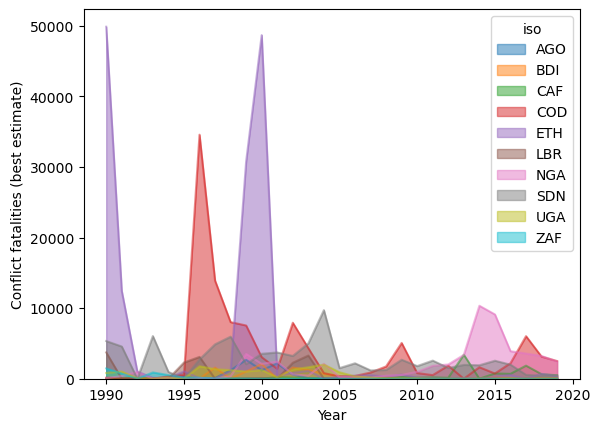

In [8]:
#time trend of the data
grouped2 = data.groupby(['iso', 'year_id']).agg({'best': 'sum'})
top_countries2 = grouped2.groupby('iso').agg({'best': 'sum'}).nlargest(10, 'best').index.tolist()
filtered2 = grouped2[grouped2.index.get_level_values('iso').isin(top_countries)]
pivoted2 = filtered2.reset_index().pivot(index='year_id', columns='iso', values='best')
pivoted2.plot.area(stacked=False)

plt.xlabel('Year')
plt.ylabel('Conflict fatalities (best estimate)')
plt.savefig('timetrend_conflict.png')

# Show the plot
plt.show()

In [13]:
top_countries2

['ETH', 'COD', 'SDN', 'NGA', 'ERI', 'COG', 'UGA', 'LBR', 'BDI', 'CAF']

In [24]:
top_countries3

['COD', 'NGA', 'SDN', 'UGA', 'BDI', 'ETH', 'CAF', 'ZAF', 'KEN', 'MLI']

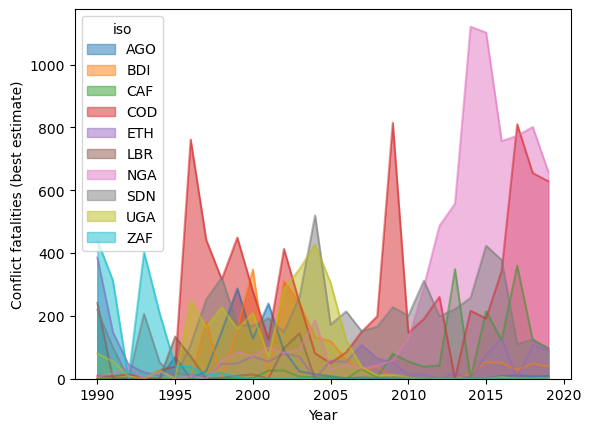

In [22]:
#time trend of the data, log fatality estimate
grouped3 = data.groupby(['iso', 'year_id']).agg({'best_log': 'sum'})
top_countries3 = grouped3.groupby('iso').agg({'best_log': 'sum'}).nlargest(10, 'best_log').index.tolist()
filtered3 = grouped3[grouped3.index.get_level_values('iso').isin(top_countries)]
pivoted3 = filtered3.reset_index().pivot(index='year_id', columns='iso', values='best_log')
pivoted3.plot.area(stacked=False)

plt.xlabel('Year')
plt.ylabel('Conflict fatalities (best estimate)')
plt.savefig('timetrend_conflict_log.png')

# Show the plot
plt.show()

,year_id,best
0,1990,63443.0
1,1991,20754.0
2,1992,2723.0
3,1993,7451.0
4,1994,2343.0
5,1995,4549.0
6,1996,43045.0
7,1997,32712.0
8,1998,24067.0
9,1999,67582.0


,year_id,daly_all
0,1990,16675926.0
1,1991,8894506.0
2,1992,2688681.0
3,1993,6472898.0
4,1994,4859987.0
5,1995,8254991.0
6,1996,11004788.0
7,1997,11301937.0
8,1998,16863246.0
9,1999,21607267.0


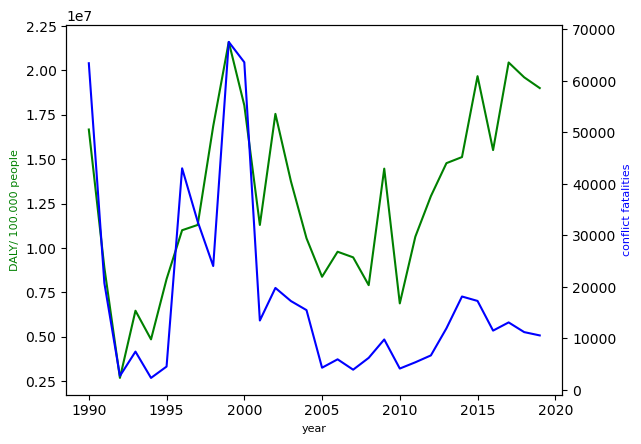

In [21]:
# combined plot
grouped_1 = data.groupby(['year_id']).agg({'best': 'sum'})
grouped_2 = data.groupby(['year_id']).agg({'daly_all': 'sum'})
grouped_1 = grouped_1.reset_index()
grouped_2 = grouped_2.reset_index()
display(grouped_1)
display(grouped_2)
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(grouped_2.year_id,
        grouped_2.daly_all,
        color="green")
# set x-axis label
ax.set_xlabel("year", fontsize =8)
# set y-axis label
ax.set_ylabel("DALY/ 100.000 people",
              color="green",
              fontsize=8)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(grouped_1.year_id, grouped_1["best"],color="blue")
ax2.set_ylabel("conflict fatalities",color="blue",fontsize=8)
plt.savefig('timetrend_combined.png')
plt.show()

,year_id,best_log
0,1990,1517.192324
1,1991,748.394198
2,1992,187.737720
3,1993,680.584518
4,1994,402.560937
5,1995,354.652958
6,1996,1331.018293
7,1997,1290.662455
8,1998,1491.575907
9,1999,1578.251631


,year_id,daly_all
0,1990,16675926.0
1,1991,8894506.0
2,1992,2688681.0
3,1993,6472898.0
4,1994,4859987.0
5,1995,8254991.0
6,1996,11004788.0
7,1997,11301937.0
8,1998,16863246.0
9,1999,21607267.0


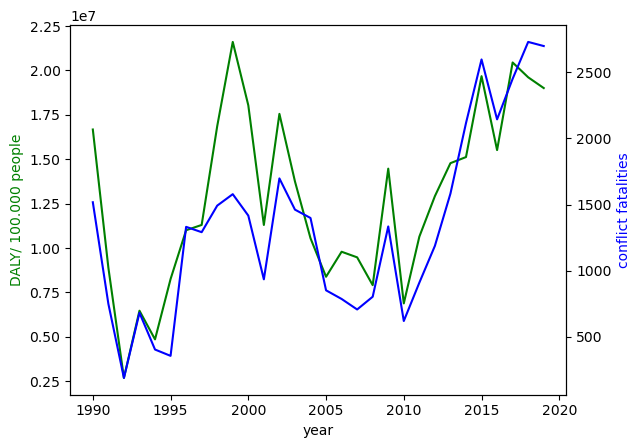

In [23]:
# combined plot
grouped_1 = data.groupby(['year_id']).agg({'best_log': 'sum'})
grouped_2 = data.groupby(['year_id']).agg({'daly_all': 'sum'})
grouped_1 = grouped_1.reset_index()
grouped_2 = grouped_2.reset_index()
display(grouped_1)
display(grouped_2)
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(grouped_2.year_id,
        grouped_2.daly_all,
        color="green")
# set x-axis label
ax.set_xlabel("year", fontsize = 10)
# set y-axis label
ax.set_ylabel("DALY/ 100.000 people",
              color="green",
              fontsize=10)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(grouped_1.year_id, grouped_1["best_log"],color="blue")
ax2.set_ylabel("conflict fatalities",color="blue",fontsize=10)
plt.savefig('timetrend_combined_log.png')
plt.show()

# start the reestimation by defining type of conflict

In [10]:
#define datasets with the different types of conflict
data_sb = data.loc[data['type_of_violence'] == 'sb']
display(data_sb)

data_ns = data.loc[data['type_of_violence'] == 'ns']
display(data_ns)

data_os = data.loc[data['type_of_violence'] == 'os']
display(data_os)

,Unnamed: 0,iso,year_id,daly_mean_All causes_No access to handwashing facility_btsx_All ages,daly_mean_All causes_Unsafe sanitation_btsx_All ages,daly_mean_All causes_Unsafe water source_btsx_All ages,"daly_mean_Communicable, maternal, neonatal, and nutritional diseases_No access to handwashing facility_btsx_All ages","daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe sanitation_btsx_All ages","daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe water source_btsx_All ages",daly_mean_Diarrheal diseases_No access to handwashing facility_btsx_All ages,...,pg_id,gdis_count,gdis_nunique,gdis_count_lag,daly_all,daly_respirat,daly_enteric,daly_diarrheal,daly_cmnn,pop_size
0,0.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,48689148.0,0.0,0.0,0.000000,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0
1,1.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,48689148.0,0.0,0.0,0.000000,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0
2,2.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,48689148.0,0.0,0.0,0.000000,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0
3,3.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,48689148.0,0.0,0.0,0.000000,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0
4,4.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,48689148.0,0.0,0.0,0.000000,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23594,23594.0,UGA,2007,1966.0,2016.0,2711.0,1966.0,2016.0,2711.0,1030.0,...,10522988.0,105.0,50.0,4.663439,6693.0,1870.0,5757.0,5757.0,6693.0,29629804.0
23595,23595.0,UGA,2007,1966.0,2016.0,2711.0,1966.0,2016.0,2711.0,1030.0,...,10522988.0,105.0,50.0,4.663439,6693.0,1870.0,5757.0,5757.0,6693.0,29629804.0
23596,23596.0,UGA,2007,1966.0,2016.0,2711.0,1966.0,2016.0,2711.0,1030.0,...,10522988.0,105.0,50.0,4.663439,6693.0,1870.0,5757.0,5757.0,6693.0,29629804.0
23597,23597.0,UGA,2007,1966.0,2016.0,2711.0,1966.0,2016.0,2711.0,1030.0,...,10522988.0,105.0,50.0,4.663439,6693.0,1870.0,5757.0,5757.0,6693.0,29629804.0


,Unnamed: 0,iso,year_id,daly_mean_All causes_No access to handwashing facility_btsx_All ages,daly_mean_All causes_Unsafe sanitation_btsx_All ages,daly_mean_All causes_Unsafe water source_btsx_All ages,"daly_mean_Communicable, maternal, neonatal, and nutritional diseases_No access to handwashing facility_btsx_All ages","daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe sanitation_btsx_All ages","daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe water source_btsx_All ages",daly_mean_Diarrheal diseases_No access to handwashing facility_btsx_All ages,...,pg_id,gdis_count,gdis_nunique,gdis_count_lag,daly_all,daly_respirat,daly_enteric,daly_diarrheal,daly_cmnn,pop_size
1067,1067.0,BDI,1997,5543.0,7311.0,9727.0,5543.0,7311.0,9727.0,3695.0,...,1373342.0,0.0,0.0,0.000000,22581.0,3694.0,20733.0,20733.0,22581.0,5923862.0
1347,1347.0,BDI,2000,4986.0,6746.0,8978.0,4986.0,6746.0,8978.0,3414.0,...,1373342.0,1.0,1.0,0.693147,20710.0,3144.0,19138.0,19138.0,20710.0,6307659.0
1684,1684.0,BDI,2003,4721.0,6427.0,8557.0,4721.0,6427.0,8557.0,3258.0,...,1373342.0,39.0,11.0,3.688879,19705.0,2926.0,18242.0,18242.0,19705.0,6860846.0
1685,1685.0,BDI,2003,4721.0,6427.0,8557.0,4721.0,6427.0,8557.0,3258.0,...,1373342.0,39.0,11.0,3.688879,19705.0,2926.0,18242.0,18242.0,19705.0,6860846.0
1686,1686.0,BDI,2003,4721.0,6427.0,8557.0,4721.0,6427.0,8557.0,3258.0,...,1373342.0,39.0,11.0,3.688879,19705.0,2926.0,18242.0,18242.0,19705.0,6860846.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25619,25619.0,ZAF,2004,1284.0,1232.0,1994.0,1284.0,1232.0,1994.0,662.0,...,42278727.0,224.0,197.0,5.416100,4510.0,1242.0,3888.0,3888.0,4510.0,48556071.0
25620,25620.0,ZAF,2004,1284.0,1232.0,1994.0,1284.0,1232.0,1994.0,662.0,...,42278727.0,224.0,197.0,5.416100,4510.0,1242.0,3888.0,3888.0,4510.0,48556071.0
25621,25621.0,ZAF,2004,1284.0,1232.0,1994.0,1284.0,1232.0,1994.0,662.0,...,42278727.0,224.0,197.0,5.416100,4510.0,1242.0,3888.0,3888.0,4510.0,48556071.0
25634,25634.0,ZAF,2016,624.0,559.0,958.0,624.0,559.0,958.0,317.0,...,42278727.0,131.0,121.0,4.882802,2141.0,612.0,1834.0,1834.0,2141.0,56422274.0


,Unnamed: 0,iso,year_id,daly_mean_All causes_No access to handwashing facility_btsx_All ages,daly_mean_All causes_Unsafe sanitation_btsx_All ages,daly_mean_All causes_Unsafe water source_btsx_All ages,"daly_mean_Communicable, maternal, neonatal, and nutritional diseases_No access to handwashing facility_btsx_All ages","daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe sanitation_btsx_All ages","daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe water source_btsx_All ages",daly_mean_Diarrheal diseases_No access to handwashing facility_btsx_All ages,...,pg_id,gdis_count,gdis_nunique,gdis_count_lag,daly_all,daly_respirat,daly_enteric,daly_diarrheal,daly_cmnn,pop_size
65,65.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,48689148.0,0.0,0.0,0.0,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0
66,66.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,48689148.0,0.0,0.0,0.0,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0
67,67.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,48689148.0,0.0,0.0,0.0,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0
68,68.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,48689148.0,0.0,0.0,0.0,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0
69,69.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,48689148.0,0.0,0.0,0.0,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25733,25733.0,ZWE,2019,1454.0,953.0,1473.0,1454.0,953.0,1473.0,532.0,...,13811629.0,0.0,0.0,0.0,3880.0,1844.0,2958.0,2958.0,3880.0,15354608.0
25734,25734.0,ZWE,2019,1454.0,953.0,1473.0,1454.0,953.0,1473.0,532.0,...,13811629.0,0.0,0.0,0.0,3880.0,1844.0,2958.0,2958.0,3880.0,15354608.0
25735,25735.0,ZWE,2019,1454.0,953.0,1473.0,1454.0,953.0,1473.0,532.0,...,13811629.0,0.0,0.0,0.0,3880.0,1844.0,2958.0,2958.0,3880.0,15354608.0
25736,25736.0,ZWE,2019,1454.0,953.0,1473.0,1454.0,953.0,1473.0,532.0,...,13811629.0,0.0,0.0,0.0,3880.0,1844.0,2958.0,2958.0,3880.0,15354608.0


# Model with fatalities estimate

In [11]:
#the country fixed effects model LAGS
from linearmodels.panel import PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','pop_size','gdp_log','lag_best_1','lag_best_2','lag_best_3','lag_best_4','lag_best_5','lag_best_6','lag_best_7','lag_best_8','lag_best_9','lag_best_10']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
fat = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_conflict_history.txt', 'w') as f:
    f.write(fat.summary.as_text())
print(fat)

                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.6720
Estimator:                   PanelOLS   R-squared (Between):             -2.5469
No. Observations:               25233   R-squared (Within):               0.6720
Date:                Tue, Aug 15 2023   R-squared (Overall):             -6.6005
Time:                        15:14:25   Log-likelihood                -2.394e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3970.1
Entities:                          29   P-value                           0.0000
Avg Obs:                       870.10   Distribution:                F(13,25191)
Min Obs:                       2.0000                                           
Max Obs:                       4593.0   F-statistic (robust):             12.325
                            

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [12]:
#the country fixed effects model WITHOUT LAGS
from linearmodels.panel import PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','pop_size','gdp_log']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
fat = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_conflict_history.txt', 'w') as f:
    f.write(fat.summary.as_text())
print(fat)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.6628
Estimator:                   PanelOLS   R-squared (Between):             -2.9665
No. Observations:               25391   R-squared (Within):               0.6628
Date:                Tue, Aug 15 2023   R-squared (Overall):             -7.2954
Time:                        15:14:26   Log-likelihood                -2.412e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.661e+04
Entities:                          33   P-value                           0.0000
Avg Obs:                       769.42   Distribution:                 F(3,25355)
Min Obs:                       1.0000                                           
Max Obs:                       4603.0   F-statistic (robust):             31.247
                            

In [13]:
#the country fixed effects model LAGS
from linearmodels.panel import PanelOLS
data1 = data_sb.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','pop_size','gdp_log','lag_best_1','lag_best_2','lag_best_3','lag_best_4','lag_best_5','lag_best_6','lag_best_7','lag_best_8','lag_best_9','lag_best_10']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
fat_sb = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_conflict_history_sb.txt', 'w') as f:
    f.write(fat_sb.summary.as_text())
print(fat_sb)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.6165
Estimator:                   PanelOLS   R-squared (Between):             -3.2530
No. Observations:                9951   R-squared (Within):               0.6165
Date:                Tue, Aug 15 2023   R-squared (Overall):             -7.9671
Time:                        15:14:26   Log-likelihood                -9.566e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1226.1
Entities:                          22   P-value                           0.0000
Avg Obs:                       452.32   Distribution:                 F(13,9916)
Min Obs:                       1.0000                                           
Max Obs:                       1680.0   F-statistic (robust):             19.544
                            

In [14]:
#the country fixed effects model LAGS
from linearmodels.panel import PanelOLS
data1 = data_os.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','pop_size','gdp_log','lag_best_1','lag_best_2','lag_best_3','lag_best_4','lag_best_5','lag_best_6','lag_best_7','lag_best_8','lag_best_9','lag_best_10']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
fat_os = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_conflict_history_os.txt', 'w') as f:
    f.write(fat_os.summary.as_text())
print(fat_os)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.6694
Estimator:                   PanelOLS   R-squared (Between):             -2.6285
No. Observations:                9738   R-squared (Within):               0.6694
Date:                Tue, Aug 15 2023   R-squared (Overall):             -5.4277
Time:                        15:14:26   Log-likelihood                -9.199e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1510.1
Entities:                          28   P-value                           0.0000
Avg Obs:                       347.79   Distribution:                 F(13,9697)
Min Obs:                       1.0000                                           
Max Obs:                       2452.0   F-statistic (robust):             86.319
                            

In [15]:
#the country fixed effects model LAGS
from linearmodels.panel import PanelOLS
data1 = data_ns.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','pop_size','gdp_log','lag_best_1','lag_best_2','lag_best_3','lag_best_4','lag_best_5','lag_best_6','lag_best_7','lag_best_8','lag_best_9','lag_best_10']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
fat_ns = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_conflict_history_ns.txt', 'w') as f:
    f.write(fat_ns.summary.as_text())
print(fat_ns)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.8825
Estimator:                   PanelOLS   R-squared (Between):             -1.4955
No. Observations:                5544   R-squared (Within):               0.8825
Date:                Tue, Aug 15 2023   R-squared (Overall):             -7.7808
Time:                        15:14:26   Log-likelihood                -4.904e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3183.0
Entities:                          21   P-value                           0.0000
Avg Obs:                       264.00   Distribution:                 F(13,5510)
Min Obs:                       1.0000                                           
Max Obs:                       1573.0   F-statistic (robust):             60.242
                            

# specification models

# STANDARD

In [16]:
# specification models without conflict history
#the country fixed effects model STANDARD
from linearmodels.panel import PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','pop_size','gdp_log', 'age0014_value','xpd_gdp_value']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
standard_spec = mod.fit(cov_type='clustered', cluster_entity=True)
with open('resuts_standard.txt', 'w') as f:
    f.write(standard_spec.summary.as_text())
print(standard_spec)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.6851
Estimator:                   PanelOLS   R-squared (Between):             -0.7155
No. Observations:               25391   R-squared (Within):               0.6851
Date:                Tue, Aug 15 2023   R-squared (Overall):             -3.6722
Time:                        15:14:26   Log-likelihood                -2.404e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.103e+04
Entities:                          33   P-value                           0.0000
Avg Obs:                       769.42   Distribution:                 F(5,25353)
Min Obs:                       1.0000                                           
Max Obs:                       4603.0   F-statistic (robust):             25.353
                            

In [17]:
# specification models without conflict history
#the country fixed effects model STANDARD
from linearmodels.panel import PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','pop_size','gdp_log','lag_best_1','lag_best_2','lag_best_3','lag_best_4','lag_best_5','lag_best_6','lag_best_7','lag_best_8','lag_best_9','lag_best_10']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
standard_spec = mod.fit(cov_type='clustered', cluster_entity=True)
with open('resuts_standard.txt', 'w') as f:
    f.write(standard_spec.summary.as_text())
print(standard_spec)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.6720
Estimator:                   PanelOLS   R-squared (Between):             -2.5469
No. Observations:               25233   R-squared (Within):               0.6720
Date:                Tue, Aug 15 2023   R-squared (Overall):             -6.6005
Time:                        15:14:26   Log-likelihood                -2.394e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3970.1
Entities:                          29   P-value                           0.0000
Avg Obs:                       870.10   Distribution:                F(13,25191)
Min Obs:                       2.0000                                           
Max Obs:                       4593.0   F-statistic (robust):             12.325
                            

In [18]:
data.columns

Index(['Unnamed: 0', 'iso', 'year_id',
       'daly_mean_All causes_No access to handwashing facility_btsx_All ages',
       'daly_mean_All causes_Unsafe sanitation_btsx_All ages',
       'daly_mean_All causes_Unsafe water source_btsx_All ages',
       'daly_mean_Communicable, maternal, neonatal, and nutritional diseases_No access to handwashing facility_btsx_All ages',
       'daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe sanitation_btsx_All ages',
       'daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe water source_btsx_All ages',
       'daly_mean_Diarrheal diseases_No access to handwashing facility_btsx_All ages',
       'daly_mean_Diarrheal diseases_Unsafe sanitation_btsx_All ages',
       'daly_mean_Diarrheal diseases_Unsafe water source_btsx_All ages',
       'daly_mean_Enteric infections_No access to handwashing facility_btsx_All ages',
       'daly_mean_Enteric infections_Unsafe sanitation_btsx_All ages',
       'daly_m

# HEALTH

In [19]:
#logtransform the healthworker variable
data['healthworker_all_log'] = np.log(data['ihme_healthworkers_all_mean'])
display(data)

,Unnamed: 0,iso,year_id,daly_mean_All causes_No access to handwashing facility_btsx_All ages,daly_mean_All causes_Unsafe sanitation_btsx_All ages,daly_mean_All causes_Unsafe water source_btsx_All ages,"daly_mean_Communicable, maternal, neonatal, and nutritional diseases_No access to handwashing facility_btsx_All ages","daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe sanitation_btsx_All ages","daly_mean_Communicable, maternal, neonatal, and nutritional diseases_Unsafe water source_btsx_All ages",daly_mean_Diarrheal diseases_No access to handwashing facility_btsx_All ages,...,gdis_count,gdis_nunique,gdis_count_lag,daly_all,daly_respirat,daly_enteric,daly_diarrheal,daly_cmnn,pop_size,healthworker_all_log
0,0.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,0.0,0.0,0.0,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0,3.390238
1,1.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,0.0,0.0,0.0,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0,3.390238
2,2.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,0.0,0.0,0.0,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0,3.390238
3,3.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,0.0,0.0,0.0,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0,3.390238
4,4.0,AGO,1995,11123.0,15295.0,21507.0,11123.0,15295.0,21507.0,8061.0,...,0.0,0.0,0.0,47925.0,6122.0,44863.0,44863.0,47925.0,13912253.0,3.390238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26390,NaN,SEN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16000781.0,NaN
26391,NaN,SLE,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8046828.0,NaN
26392,NaN,SOM,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15981300.0,NaN
26393,NaN,STP,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214599.0,NaN


In [20]:
#the country fixed effects model HEALTH
from linearmodels.panel import PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','dah_total_log','healthworker_all_log']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
health_spec = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_health_specification.txt', 'w') as f:
    f.write(health_spec.summary.as_text())
print(health_spec)

                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.6780
Estimator:                   PanelOLS   R-squared (Between):             -20.013
No. Observations:               23372   R-squared (Within):               0.6780
Date:                Tue, Aug 15 2023   R-squared (Overall):             -24.841
Time:                        15:14:27   Log-likelihood                 -2.21e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.638e+04
Entities:                          31   P-value                           0.0000
Avg Obs:                       753.94   Distribution:                 F(3,23338)
Min Obs:                       1.0000                                           
Max Obs:                       4092.0   F-statistic (robust):             17.437
                            

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


## DISASTER

In [21]:
#logtransform the death variable
data['death_tot_log'] = np.log1p(data['death_tot'])

In [22]:
#the country fixed effects model DISASTER
from linearmodels.panel import PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','access_drinkwater_index', 'access_sani_index', 'death_tot_log','gdis_count_lag']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
disaster_spec = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_disaster_specification.txt', 'w') as f:
    f.write(disaster_spec.summary.as_text())
print(disaster_spec)

                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.5625
Estimator:                   PanelOLS   R-squared (Between):             -4.0831
No. Observations:               22128   R-squared (Within):               0.5625
Date:                Tue, Aug 15 2023   R-squared (Overall):             -6.2960
Time:                        15:14:27   Log-likelihood                -2.113e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5681.9
Entities:                          31   P-value                           0.0000
Avg Obs:                       713.81   Distribution:                 F(5,22092)
Min Obs:                       1.0000                                           
Max Obs:                       4569.0   F-statistic (robust):             109.59
                            

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


## all

In [23]:
## the country fixed effects model ALL
from linearmodels.panel import PanelOLS
data2 = data.set_index(['iso','year_id'])
y= data2['daly_all']
x= data2[['best_log','lag_best_1','lag_best_2','lag_best_3','lag_best_4',
          'lag_best_5','lag_best_6','lag_best_7','lag_best_8','lag_best_9',
          'lag_best_10','pop_size','gdp_log', 'age0014_value','xpd_gdp_value',
          'dah_total_log','healthworker_all_log','access_drinkwater_index', 
          'access_sani_index', 'death_tot_log','gdis_count_lag']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
model_overfit = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_all.txt', 'w') as f:
    f.write(model_overfit.summary.as_text())
print(model_overfit)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.8225
Estimator:                   PanelOLS   R-squared (Between):             -42.500
No. Observations:               20031   R-squared (Within):               0.8225
Date:                Tue, Aug 15 2023   R-squared (Overall):             -55.387
Time:                        15:14:27   Log-likelihood                -1.819e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4408.1
Entities:                          28   P-value                           0.0000
Avg Obs:                       715.39   Distribution:                F(21,19982)
Min Obs:                       1.0000                                           
Max Obs:                       4048.0   F-statistic (robust):          7.097e+04
                            

## now do it for the lags separately

normal fat estimate

In [24]:
#the country fixed effects model STANDARD
from linearmodels.panel import PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','gdp_log', 'age0014_value','xpd_gdp_value',]]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
standard_spec = mod.fit(cov_type='clustered', cluster_entity=True)
with open('resuts_standard.txt', 'w') as f:
    f.write(standard_spec.summary.as_text())
print(standard_spec)

                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.3193
Estimator:                   PanelOLS   R-squared (Between):              0.5553
No. Observations:               25391   R-squared (Within):               0.3193
Date:                Tue, Aug 15 2023   R-squared (Overall):              0.4926
Time:                        15:14:27   Log-likelihood                -2.502e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2973.8
Entities:                          33   P-value                           0.0000
Avg Obs:                       769.42   Distribution:                 F(4,25354)
Min Obs:                       1.0000                                           
Max Obs:                       4603.0   F-statistic (robust):             14.180
                            

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [25]:
#the country fixed effects model HEALTH
from linearmodels.panel import PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','dah_total_log','healthworker_all_log']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
health_spec = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_health_specification.txt', 'w') as f:
    f.write(health_spec.summary.as_text())
print(health_spec)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.6780
Estimator:                   PanelOLS   R-squared (Between):             -20.013
No. Observations:               23372   R-squared (Within):               0.6780
Date:                Tue, Aug 15 2023   R-squared (Overall):             -24.841
Time:                        15:14:27   Log-likelihood                 -2.21e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.638e+04
Entities:                          31   P-value                           0.0000
Avg Obs:                       753.94   Distribution:                 F(3,23338)
Min Obs:                       1.0000                                           
Max Obs:                       4092.0   F-statistic (robust):             17.437
                            

In [26]:
#the country fixed effects model DISASTER
from linearmodels.panel import PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','access_drinkwater_index', 'access_sani_index', 'death_tot_log','gdis_count_lag']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
disaster_spec = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_disaster_specification.txt', 'w') as f:
    f.write(disaster_spec.summary.as_text())
print(disaster_spec)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.5625
Estimator:                   PanelOLS   R-squared (Between):             -4.0831
No. Observations:               22128   R-squared (Within):               0.5625
Date:                Tue, Aug 15 2023   R-squared (Overall):             -6.2960
Time:                        15:14:27   Log-likelihood                -2.113e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5681.9
Entities:                          31   P-value                           0.0000
Avg Obs:                       713.81   Distribution:                 F(5,22092)
Min Obs:                       1.0000                                           
Max Obs:                       4569.0   F-statistic (robust):             109.59
                            

lag 5

In [27]:
# lag 5
#the country fixed effects model standard
from linearmodels.panel import PanelOLS
data2 = data.set_index(['iso','year_id'])
y= data2['daly_all']
x= data2[['lag_best_5','gdp_log', 'age0014_value','xpd_gdp_value']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
standard_lag5 = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_all.txt', 'w') as f:
    f.write(standard_lag5.summary.as_text())
print(standard_lag5)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.3195
Estimator:                   PanelOLS   R-squared (Between):              0.5831
No. Observations:               25318   R-squared (Within):               0.3195
Date:                Tue, Aug 15 2023   R-squared (Overall):              0.5018
Time:                        15:14:28   Log-likelihood                -2.495e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2967.1
Entities:                          30   P-value                           0.0000
Avg Obs:                       843.93   Distribution:                 F(4,25284)
Min Obs:                       4.0000                                           
Max Obs:                       4598.0   F-statistic (robust):             13.869
                            

In [28]:
# lag 5
#the country fixed effects model health
from linearmodels.panel import PanelOLS
data2 = data.set_index(['iso','year_id'])
y= data2['daly_all']
x= data2[['lag_best_5','dah_total_log','healthworker_all_log']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
health_lag5 = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_all.txt', 'w') as f:
    f.write(health_lag5.summary.as_text())
print(health_lag5)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.6786
Estimator:                   PanelOLS   R-squared (Between):             -19.605
No. Observations:               23303   R-squared (Within):               0.6786
Date:                Tue, Aug 15 2023   R-squared (Overall):             -24.853
Time:                        15:14:28   Log-likelihood                -2.203e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.638e+04
Entities:                          30   P-value                           0.0000
Avg Obs:                       776.77   Distribution:                 F(3,23270)
Min Obs:                       4.0000                                           
Max Obs:                       4087.0   F-statistic (robust):             17.419
                            

In [29]:
# lag 5
#the country fixed effects model disaster
from linearmodels.panel import PanelOLS
data2 = data.set_index(['iso','year_id'])
y= data2['daly_all']
x= data2[['lag_best_5','access_drinkwater_index', 'access_sani_index', 'death_tot_log','gdis_count_lag']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
disaster_lag5 = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_all.txt', 'w') as f:
    f.write(disaster_lag5.summary.as_text())
print(disaster_lag5)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.5635
Estimator:                   PanelOLS   R-squared (Between):             -4.1702
No. Observations:               22057   R-squared (Within):               0.5635
Date:                Tue, Aug 15 2023   R-squared (Overall):             -6.3353
Time:                        15:14:28   Log-likelihood                -2.106e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5685.6
Entities:                          29   P-value                           0.0000
Avg Obs:                       760.59   Distribution:                 F(5,22023)
Min Obs:                       1.0000                                           
Max Obs:                       4564.0   F-statistic (robust):             112.71
                            

lag 10

In [30]:
# lag 10
#the country fixed effects model standard
from linearmodels.panel import PanelOLS
data2 = data.set_index(['iso','year_id'])
y= data2['daly_all']
x= data2[['lag_best_10','gdp_log','age0014_value','xpd_gdp_value']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
standard_lag10 = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_all.txt', 'w') as f:
    f.write(standard_lag10.summary.as_text())
print(standard_lag10)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.3181
Estimator:                   PanelOLS   R-squared (Between):              0.5936
No. Observations:               25248   R-squared (Within):               0.3181
Date:                Tue, Aug 15 2023   R-squared (Overall):              0.5146
Time:                        15:14:28   Log-likelihood                -2.488e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2940.2
Entities:                          31   P-value                           0.0000
Avg Obs:                       814.45   Distribution:                 F(4,25213)
Min Obs:                       1.0000                                           
Max Obs:                       4593.0   F-statistic (robust):             13.762
                            

In [31]:
# lag 10
#the country fixed effects model health
from linearmodels.panel import PanelOLS
data2 = data.set_index(['iso','year_id'])
y= data2['daly_all']
x= data2[['lag_best_10','dah_total_log','healthworker_all_log']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
health_lag10 = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_all.txt', 'w') as f:
    f.write(health_lag10.summary.as_text())
print(health_lag10)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.6792
Estimator:                   PanelOLS   R-squared (Between):             -19.295
No. Observations:               23233   R-squared (Within):               0.6792
Date:                Tue, Aug 15 2023   R-squared (Overall):             -24.863
Time:                        15:14:28   Log-likelihood                -2.197e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.637e+04
Entities:                          31   P-value                           0.0000
Avg Obs:                       749.45   Distribution:                 F(3,23199)
Min Obs:                       1.0000                                           
Max Obs:                       4082.0   F-statistic (robust):             17.384
                            

In [32]:
#the country fixed effects model disaster
from linearmodels.panel import PanelOLS
data2 = data.set_index(['iso','year_id'])
y= data2['daly_all']
x= data2[['lag_best_10','access_drinkwater_index', 'access_sani_index', 'death_tot_log','gdis_count_lag']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
disaster_lag10 = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_all.txt', 'w') as f:
    f.write(disaster_lag10.summary.as_text())
print(disaster_lag10)

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               daly_all   R-squared:                        0.5619
Estimator:                   PanelOLS   R-squared (Between):             -4.2033
No. Observations:               21989   R-squared (Within):               0.5619
Date:                Tue, Aug 15 2023   R-squared (Overall):             -6.3734
Time:                        15:14:29   Log-likelihood                -2.101e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5631.5
Entities:                          28   P-value                           0.0000
Avg Obs:                       785.32   Distribution:                 F(5,21956)
Min Obs:                       1.0000                                           
Max Obs:                       4559.0   F-statistic (robust):             113.34
                            

## model without influential cases

In [33]:
# Convert the 'Entity' and 'Time' columns to categorical variables
#data_analysis['Entity'] = pd.Categorical(data_analysis['iso'])


# Estimate the fixed effects model using PanelOLS
y= data1['daly_all']
x= data1[['best_log','pop_size','gdp_log', 'age0014_value','xpd_gdp_value',]]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
results = mod.fit(cov_type='clustered', cluster_entity=True)
# Calculate the residuals manually
y = data['daly_all']
X = data[['best_log','gdp_log', 'age0014_value','xpd_gdp_value',]]
residuals = y - X @ results.params

# Calculate the standardized residuals
mean_residuals = residuals.mean()
std_residuals = residuals.std()
std_residuals = (residuals - mean_residuals) / std_residuals

# Identify influential observations based on standardized residuals
influential_obs = std_residuals.abs() > 2

# Print influential observations
if influential_obs.any():
    print("Influential observations:")
    for i, obs in enumerate(influential_obs):
        if obs:
            print(f"Observation {i + 1}")
else:
    print("No influential observations found.")

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


ValueError: matrices are not aligned

In [ ]:
results

In [35]:
# Convert the 'Entity' and 'Time' columns to categorical variables
#data_analysis['Entity'] = pd.Categorical(data_analysis['iso'])

# Estimate the fixed effects model using PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','dah_total_log','healthworker_all_log']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
results = mod.fit(cov_type='clustered', cluster_entity=True)
# Calculate the residuals manually
y = data['daly_all']
X = data[['best_log','dah_total_log','healthworkers_all_log']]
residuals = y - X @ results.params

# Calculate the standardized residuals
mean_residuals = residuals.mean()
std_residuals = residuals.std()
std_residuals = (residuals - mean_residuals) / std_residuals

# Identify influential observations based on standardized residuals
influential_obs = std_residuals.abs() > 2

# Print influential observations
if influential_obs.any():
    print("Influential observations:")
    for i, obs in enumerate(influential_obs):
        if obs:
            print(f"Observation {i + 1}")
else:
    print("No influential observations found.")

/Users/NatStrom/opt/miniconda3/envs/viewser/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


KeyError: "['healthworkers_all_log'] not in index"

In [ ]:
results

In [ ]:
# Convert the 'Entity' and 'Time' columns to categorical variables
#data_analysis['Entity'] = pd.Categorical(data_analysis['iso'])


# Estimate the fixed effects model using PanelOLS
data1 = data.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','access_drinkwater_index', 'access_sani_index', 'death_tot_log','gdis_count_lag']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
results = mod.fit(cov_type='clustered', cluster_entity=True)
# Calculate the residuals manually
y = data_analysis['daly_all']
X = data_analysis[['best_log','access_drinkwater_index', 'access_sani_index', 'death_tot_log','gdis_count_lag']]
residuals = y - X @ results.params

# Calculate the standardized residuals
mean_residuals = residuals.mean()
std_residuals = residuals.std()
std_residuals = (residuals - mean_residuals) / std_residuals

# Identify influential observations based on standardized residuals
influential_obs = std_residuals.abs() > 2

# Print influential observations
if influential_obs.any():
    print("Influential observations:")
    for i, obs in enumerate(influential_obs):
        if obs:
            print(f"Observation {i + 1}")
else:
    print("No influential observations found.")

In [ ]:
results

In [ ]:
# Exclude influential observations from the data
data_filtered = data[~influential_obs]

In [ ]:
#the country fixed effects model LAGS, excluding influential cases
from linearmodels.panel import PanelOLS
data1 = data_filtered.set_index(['iso','year_id'])
y= data1['daly_all']
x= data1[['best_log','pop_size','gdp_log','lag_best_1','lag_best_2','lag_best_3','lag_best_4','lag_best_5','lag_best_6','lag_best_7','lag_best_8','lag_best_9','lag_best_10']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
model_inf1 = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_influential_.txt', 'w') as f:
    f.write(model_inf1.summary.as_text())
print(model_inf1)

In [ ]:
## the country fixed effects model ALL, excluding influential cases
from linearmodels.panel import PanelOLS
data2 = data_filtered.set_index(['iso','year_id'])
y= data2['daly_all']
x= data2[['best_log','lag_best_1','lag_best_2','lag_best_3','lag_best_4',
          'lag_best_5','lag_best_6','lag_best_7','lag_best_8','lag_best_9',
          'lag_best_10','pop_size','gdp_log', 'age0014_value','xpd_gdp_value',
          'dah_total_log','healthworker_all_log','access_drinkwater_index', 
          'access_sani_index', 'death_tot_log','gdis_count_lag']]
mod = PanelOLS(y,x, entity_effects=True,time_effects=False)
model_inf2 = mod.fit(cov_type='clustered', cluster_entity=True)
with open('results_influential_all.txt', 'w') as f:
    f.write(model_inf2.summary.as_text())
print(model_inf2)

# plot the estimates for the lags to get the temporal effect

In [ ]:
#choose the version of dependent, this will run only one type of formula at a time, so no groupings by age and sex
#additionaly this was made for civil war binary variable, but just in case if we want to do ged, the variable_portion_to_strip should enable the use of something where variable names are identical and t0 or tl1 carry the information on temporal placement of the variable. 
version_of_dependent = ''
variable_portion_to_strip = 'civil_war_binary_'
#blank dataframe

for ghe_number in ['10', '600', '1510']:
    for sex in ['btsx']:
        for age_group in ['all_ages']:
            var = f"{version_of_dependent}level1_ghe{ghe_number}_{age_group}_{sex}_rate"
            indep=violence_variables_ln_special+violence_splag+other_controls
            indep_in_formula = '+'.join(indep)
            
            
            
            model2 = ols(formula=var+f"~ {indep_in_formula} +C(year_id)+C(country_id)",data=test).fit()
            fe_groups = test.copy()
            
            for i in [var,'country_id', 'year_id']+indep:
                fe_groups = fe_groups[pd.notnull(fe_groups[i])]
                
            model3 = ols(formula=var+f"~ {indep_in_formula} + C(year_id)+C(country_id)",data=fe_groups).fit(cov_type='cluster', cov_kwds={'groups': fe_groups ['country_id']})
            
            se = round(model3.bse,3)
            pvals = round(model3.pvalues,3)
            coeff = round(model3.params,10)
            nobs = int(model3.nobs)
            r2 = round(model3.rsquared_adj, 2)
            dep = var
            
            #things I want to store, age, sex, and ghe type
            results_df = pd.DataFrame({"coeff":coeff,"s.e.":se, "pvals":pvals})
            results_df = results_df.drop('pvals', axis=1)
        

            results = results_df.query(f"index in {violence_variables_ln_special}")
            results = results.copy()
            results['order'] = results.index.str.strip(variable_portion_to_strip)
            
            results['ll'] = results['coeff'] - 1.96*(results['s.e.'])
            results['hl'] = results['coeff'] + 1.96*(results['s.e.'])

            data = results.copy()
            #the following creates the error term which will be used to make the confidence interval
            errors = data['coeff'] - data['ll']
            data['errors'] = errors

            #the following should order things together
            #for our case we want them to be age groups
            #we need to specify the order of age groups, i want all ages to occur last

            custom_dict = dict(zip([f"tl{i}" for i in range(10, 0, -1)]+[f"t{j}" for j in range(0,11)], range(-10, 11)))
            data = data.sort_values(by=['order'], key = lambda x: x.map(custom_dict))
            data['variables'] = data.index
            
            sns.set_context('poster')

            #figure, axes, and plot
            fig,ax = plt.subplots(figsize = (15,10))
            
            
            data.plot(x='variables', y='coeff', kind='bar', ax=ax, color=['orange']*10 + ['steelblue']*(len(data)-10), fontsize=22, ecolor='black',capsize=0,yerr='errors', legend=False)
            
            # Set title & labels
            plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
            ax.set_ylabel('Coefficients',fontsize=22)
            ax.set_xlabel('Time',fontsize=22)
    
            # Coefficients
            ax.scatter(x=pd.np.arange(data.shape[0]), marker='o', s=80, y=data['coeff'], color='black')
            
            ax.set_xticklabels([custom_dict.get(label) for label in data['order']])

    
            # Line to define zero on the y-axis
            ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
            
            filename = f"dep_{version_of_dependent}level1_ghe{ghe_number}_{age_group}_{sex}_indep_{variable_portion_to_strip}tlag_tlead_coefficient_plot.png"
            
            plt.savefig(f"{output}figures/{figure_folder}/{filename}", dpi = 300)
            plt.close()